In [19]:
from articlehelper import ArticleHandler, RePostprocessor, map_paragraphs, map_category_bruk
import numpy as np
import pandas as pd
from clfhelpers import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, mutual_info_score, adjusted_mutual_info_score
from analyzers import PosAnalyzer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif

MASK = 'data\\bruk'
zip_fname = MASK + '.zip'
train_fname = MASK + '_train.txt'
test_fname = MASK + '_test.txt'

In [20]:
train = ArticleHandler.read_zip_list(zip_fname, train_fname, lang='uk')
test = ArticleHandler.read_zip_list(zip_fname, test_fname, lang='uk')
print(len(train), len(test))

262 88


In [21]:
def add_category(articles, map_category):
    for x in articles:
        x['category'] = map_category(x)

add_category(train, map_category_bruk)        
add_category(test, map_category_bruk)

In [22]:
df_train = pd.DataFrame.from_dict(map_paragraphs(train, map_category_bruk))
df_train.groupby(['category']).count()

,doc,text
category,,
fiction,1480,1480
press,1004,1004
prof_science,825,825


In [23]:
df_test = pd.DataFrame.from_dict(map_paragraphs(test, map_category_bruk))
df_test.groupby(['category']).count()

,doc,text
category,,
fiction,548,548
press,356,356
prof_science,299,299


In [24]:
X_train = df_train['text'].values
X_test = df_test['text'].values
y_train = df_train['category'].values
y_test = df_test['category'].values

In [25]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

3309 1203 3309 1203


In [26]:
class ClfFactoryPOS:
    def get_analyzer(self):
        return PosAnalyzer.analyze
    
    def make_classifier(self):
        return MultinomialNB(alpha=0.05)
    
    def make_vectorizer(self):
        return TfidfVectorizer(tokenizer=self.get_analyzer(), ngram_range=(2, 4), min_df=10)

factory = ClfFactoryPOS()
s = X_train[0] +'\n'+ X_train[1]
print(s)
print(factory.get_analyzer()(s))   

Коли можливості передавання даних у Мережі вдосконалилися до вільного передавання звуку та зображення, почали розвиватися нові види веб-ресурсів. З’явилися прямі трансляції якихось подій, Інтернет-радіо, а також подкасти, почасти схожі на радіо- чи телевізійні передачі в записі.
ДЛЯ НАШОГО ВУХА ДЕЩО НЕЗВИЧНО ЗВУЧИТЬ СКЛАД «ПОД», ТОЖ В УКРАЇНСЬКОМОВНОМУ ІНТЕРНЕТІ ПАРАЛЕЛЬНО ВЖИВАЄТЬСЯ Й ВАРІАНТ «ПІДКАСТИНГ», «ПІДКАСТ». ТАКЕ ПРИСТОСУВАННЯ ТЕРМІНІВ ДО ОРФОЕПІЧНИХ ТРАДИЦІЙ КРАЮ ВІДБУВАЄТЬСЯ ДОСИТЬ ЧАСТО, В РІЗНИХ МОВАХ.
['<P>', '<P>', '<P>', 'PRCL', 'NOUN', 'NOUN', 'ADJF', 'PREP', 'NOUN', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'NOUN', ',', 'VERB', 'VERB', 'ADJF', 'NOUN', 'NOUN', '-', 'NOUN', '.', 'VERB', 'ADJF', 'NOUN', 'NPRO', 'NOUN', ',', 'NOUN', '-', 'NOUN', ',', 'CONJ', 'CONJ', 'NOUN', ',', 'ADVB', 'ADJF', 'INTJ', 'NOUN', '-', 'PRCL', 'ADJF', 'NOUN', 'PREP', 'NOUN', '.', '</P>', '</P>', '</P>', '<P>', '<P>', '<P>', 'PREP', 'NPRO', 'NOUN', 'NPRO', 'ADVB', 'VERB', 'NOUN', 'UNDEF

In [27]:
tfidf = factory.make_vectorizer()
clf = factory.make_classifier()

vtrain = tfidf.fit_transform(X_train)
vtest = tfidf.transform(X_test)

In [28]:
print(vtrain.shape, vtest.shape)

(3309, 5655) (1203, 5655)


In [29]:
clf.fit(vtrain, y_train)
y_predicted = clf.predict(vtest)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))

              precision    recall  f1-score   support

     fiction       0.78      0.90      0.83       548
       press       0.59      0.56      0.57       356
prof_science       0.58      0.44      0.50       299

 avg / total       0.67      0.69      0.67      1203

0.25874857960721864


In [30]:
show_all_top_features(tfidf, clf, n=40)

fiction:
<P> <P>: -5.12133663178971
</P> </P>: -5.12133663178971
NOUN ,: -5.1463419125888095
ADJF NOUN: -5.355789608555155
NOUN NOUN: -5.42313192715957
NOUN VERB: -5.423992454438473
NOUN .: -5.439538123052756
VERB NOUN: -5.458603699190761
PRCL VERB: -5.532531745042368
, CONJ: -5.557232993696597
VERB ,: -5.570527086409992
PREP NOUN: -5.624389826203801
NPRO VERB: -5.670429785594461
NPRO NOUN: -5.705677128804396
, PRCL: -5.7634295137888465
VERB .: -5.801778093142145
<P> <P> <P>: -5.813904951646375
</P> </P> </P>: -5.813904951646375
CONJ VERB: -5.929451209474956
. </P> </P> </P>: -5.961250027249359
. </P> </P>: -5.961250027249359
. </P>: -5.961250027249359
ADVB VERB: -6.000425363313578
CONJ NOUN: -6.00221545886124
VERB NPRO: -6.050152153173752
CONJ NPRO: -6.055373185376239
<P> UNDEF: -6.063641451849568
<P> <P> UNDEF: -6.063641451849568
<P> <P> <P> UNDEF: -6.063641451849568
VERB PREP: -6.089329278225257
, VERB: -6.105294910782492
NOUN CONJ: -6.131677706536156
NOUN , CONJ: -6.177551173317115

In [31]:
percentile = 70
sel_perc = SelectPercentile(mutual_info_classif, percentile)
vtrain_perc = sel_perc.fit_transform(vtrain, y_train)
vtest_perc = sel_perc.transform(vtest)

              precision    recall  f1-score   support

     fiction       0.78      0.90      0.84       548
       press       0.60      0.58      0.59       356
prof_science       0.59      0.44      0.51       299

 avg / total       0.68      0.69      0.68      1203

0.26753224831026684


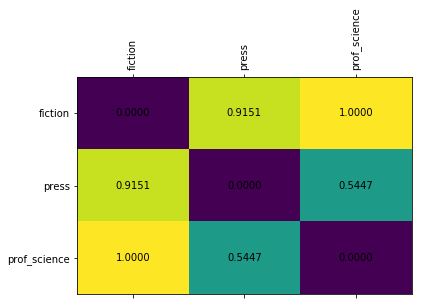

In [32]:
clf.fit(vtrain_perc, y_train)
y_predicted = clf.predict(vtest_perc)
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))
plot_clf_classes_distances(clf)

In [33]:
show_all_top_features(tfidf, clf, n=40)

fiction:
. ADVB VERB NOUN: -5.02423390023325
. ADVB PREP NOUN: -5.02423390023325
ADVB ADVB VERB ,: -5.04923918103235
</P> </P>: -5.258686876998696
CONJ NOUN NPRO PRCL: -5.326029195603111
INTJ CONJ: -5.326889722882013
ADVB PRCL PRCL: -5.342435391496297
NPRO ADVB VERB NOUN: -5.361500967634302
NOUN NOUN -: -5.4354290134859085
, ADJF PREP NOUN: -5.4601302621401375
NOUN VERB CONJ PREP: -5.473424354853533
NOUN NOUN VERB ADVB: -5.527287094647342
NOUN . PRCL ,: -5.5733270540380015
NOUN , NOUN ADJF: -5.608574397247937
, NOUN . NOUN: -5.666326782232387
NOUN VERB UNDEF: -5.704675361585686
. CONJ ,: -5.716802220089916
. ADVB VERB: -5.716802220089916
ADJF PREP NOUN ,: -5.832348477918496
, PRCL PRCL ADVB: -5.8641472956928995
, PRCL PRCL: -5.8641472956928995
, PRCL NPRO VERB: -5.8641472956928995
ADJF . </P> </P>: -5.903322631757119
ADJF NOUN , CONJ: -5.905112727304781
NPRO NOUN CONJ VERB: -5.953049421617292
ADJF NOUN NOUN (: -5.95827045381978
. PRCL: -5.966538720293109
. NOUN ,: -5.966538720293109
. 

In [34]:
df_test = pd.DataFrame.from_dict(test)
df_test.groupby(['category']).count()

,alt_orth,author_name,author_name_1,author_name_2,author_surname,author_surname_1,author_surname_2,body,comments,errors,...,length,pages,publ_in,publ_part,publ_place,publisher,text,title,url,year
category,,,,,,,,,,,,,,,,,,,,,
fiction,25,24,1,1,24,1,1,25,2,17,...,25,24,5,1,24,24,25,25,0,25
press,44,32,1,1,32,1,1,44,2,25,...,44,3,43,4,30,0,44,44,41,44
prof_science,19,12,4,4,12,4,4,19,0,15,...,19,15,10,8,17,13,19,19,4,19


In [35]:
X_test = df_test['text'].values
y_test = df_test['category']
vtest = tfidf.transform(X_test)
vtest_perc = sel_perc.transform(vtest)
y_predicted = clf.predict(vtest_perc.toarray())
print(classification_report(y_test, y_predicted, clf.classes_))
print(adjusted_mutual_info_score(y_test, y_predicted))

              precision    recall  f1-score   support

     fiction       0.71      1.00      0.83        25
       press       0.84      0.70      0.77        44
prof_science       0.69      0.58      0.63        19

 avg / total       0.77      0.76      0.76        88

0.41010259982438896


In [37]:
from sklearn.externals import joblib
joblib.dump(clf, 'clf_bruk_MNB_POS.pkl') 
joblib.dump(tfidf, 'tfidf_bruk_MNB_POS.pkl')
joblib.dump(sel_perc, 'featsel_bruk_MNB_POS.pkl')

['featsel_bruk_MNB_POS.pkl']